In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [2]:
image = np.load('./data/image.npy')
sinogram = np.load('./data/sinogram.npy')
r_axis = np.load('./data/r_axis.npy')
thetas = np.load('./data/thetas.npy')
dr = r_axis[1] - r_axis[0]

In [3]:
sinogram.shape

(320, 36)

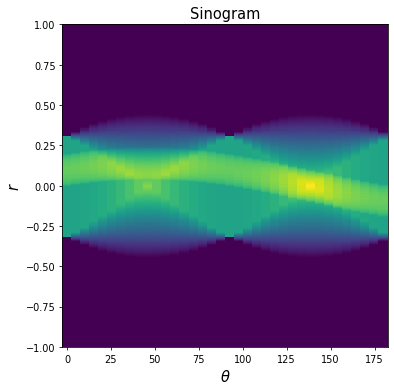

In [4]:
# Visualize
_r = np.linspace(-1, 1, sinogram.shape[0])
_theta = np.linspace(0, 180, sinogram.shape[1])
xv_rt, yv_rt = np.meshgrid(_theta,_r)
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pcolor(xv_rt,yv_rt,sinogram, shading='auto')
ax.set_title('Sinogram',fontsize=15)
ax.set_xlabel(r'$\theta$',fontsize=15)
ax.set_ylabel(r'$r$',fontsize=15)
plt.show()

In [15]:
p = sinogram.copy() # this is the data coming from the CT scanner

In [16]:
from scipy.interpolate import RectBivariateSpline
p_interp = RectBivariateSpline(r_axis,thetas, p)

In [17]:
p_interp(0.22,40)

array([[0.5720763]])

In [18]:
# visualize the interpolated sinogram
# say that we want a 2-fold better resolution across r and a 3-fold across theta
_r_new = np.linspace(-1, 1, sinogram.shape[0]*2)
_theta_new = np.linspace(0, 180, sinogram.shape[1]*3)
xv_rt_new, yv_rt_new = np.meshgrid(_theta_new,_r_new)

In [19]:
python_efficient = True
python_efficient = False

In [24]:
if python_efficient:
    sinogram_interp = np.vectorize(p_interp)(yv_rt_new, xv_rt_new)# same speed, less intuitive, less code
else:
    sinogram_interp = np.zeros((len(_r_new),len(_theta_new)))
    for r_count, r_value in enumerate(_r_new):
        for theta_count, theta_value in enumerate(_theta_new):
            sinogram_interp[r_count, theta_count] = p_interp(r_value, theta_value)

/tmp/ipykernel_63293/3194533278.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sinogram_interp[r_count, theta_count] = p_interp(r_value, theta_value)


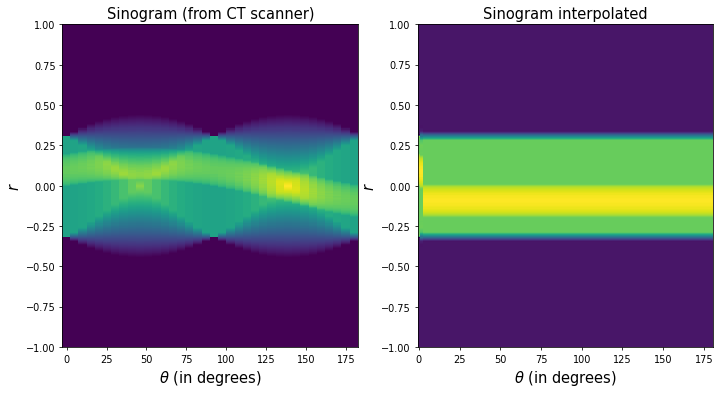

In [26]:
# Visualize
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].pcolor(xv_rt,yv_rt,sinogram, shading='auto')
ax[0].set_title('Sinogram (from CT scanner)',fontsize=15)
ax[0].set_xlabel(r'$\theta$ (in degrees)',fontsize=15)
ax[0].set_ylabel(r'$r$',fontsize=15)

ax[1].pcolor(xv_rt_new,yv_rt_new,sinogram_interp, shading='auto')
ax[1].set_title('Sinogram interpolated',fontsize=15)
ax[1].set_xlabel(r'$\theta$ (in degrees)',fontsize=15)
ax[1].set_ylabel(r'$r$',fontsize=15)
plt.show()

In [27]:
thetas_rad = np.deg2rad(thetas)
p_interp = RectBivariateSpline(r_axis, thetas_rad, p)

In [28]:
p.shape

(320, 36)

In [29]:
Delta_theta = thetas_rad[1] - thetas_rad[0]

_ = np.linspace(-1, 1, image.shape[0])

f_BP = np.zeros((len(_),len(_)))

for x_count, x_value in enumerate(_):
    for y_count, y_value in enumerate(_):
        
        # Find out the values of r for each angle: e.g. if you have N=36 angles, then a certain point x, y will have 36 r values, one for each projection
        r_values = x_value*np.cos(thetas_rad) + y_value*np.sin(thetas_rad)
        
        # Find out the value of the projection p(r,theta) for each of the N (e.g. 36) pairs of r and angle theta: remember that we need interpolation
        p_rs_thetas = p_interp(r_values, thetas_rad,grid=False)
        
        # Now we have all the values of the projections corresponding to the point at coordinates x , y.
        # We need to sum all of them. To fulfill the integration, remember the Delta_theta
        
        f_BP[x_count,y_count] = p_rs_thetas.flatten().sum()*Delta_theta # YOUR CODE HERE

In [30]:
print('the function f(x,y) reconstructed with backprojection (BP) has shape',f_BP.shape)

the function f(x,y) reconstructed with backprojection (BP) has shape (320, 320)


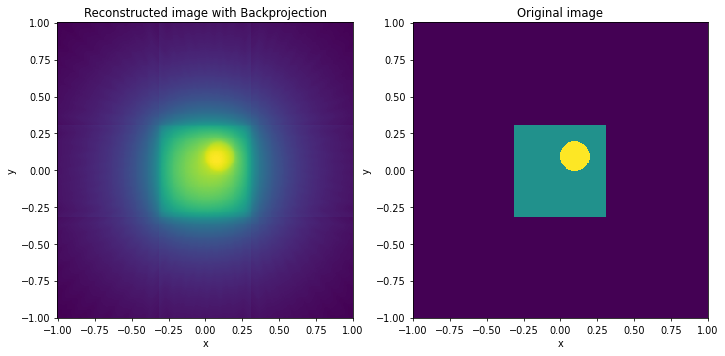

In [32]:
# Define some image pixel coordinates
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].pcolor(xv,yv,f_BP, shading='auto')
ax[0].set_title('Reconstructed image with Backprojection')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_aspect('equal')

ax[1].pcolor(xv,yv,image, shading='auto')
ax[1].set_title('Original image')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_aspect('equal')
plt.show()

In [33]:
def find_all_y_given_x_coordinate(x_coord,xv,yv):

    resolution = np.abs(xv[0,1]-xv[0,0])
    a = np.where(np.abs(xv-x_coord) <= resolution)

    even = [x for x in range(len(a[0])) if x%2==0]
    odd = [x for x in range(len(a[0])) if x%2!=0]

    if x_coord>=0:
        idxs = (a[0][even],a[1][even])
    else:
        idxs = (a[0][odd],a[1][odd])
    return idxs

def find_all_x_given_y_coordinate(y_coord,xv,yv):

    resolution = np.abs(yv[1,0]-yv[0,0])
    a = np.where(np.abs(yv-y_coord) <= resolution)

    even = [x for x in range(len(a[0])) if x%2==0]
    odd = [x for x in range(len(a[0])) if x%2!=0]
    lenA = int(len(a[0])/2)
    if y_coord>=0:
        idxs = (a[0][0:lenA],a[1][0:lenA])
    else:
        idxs = (a[0][lenA:],a[1][lenA:])
    return idxs

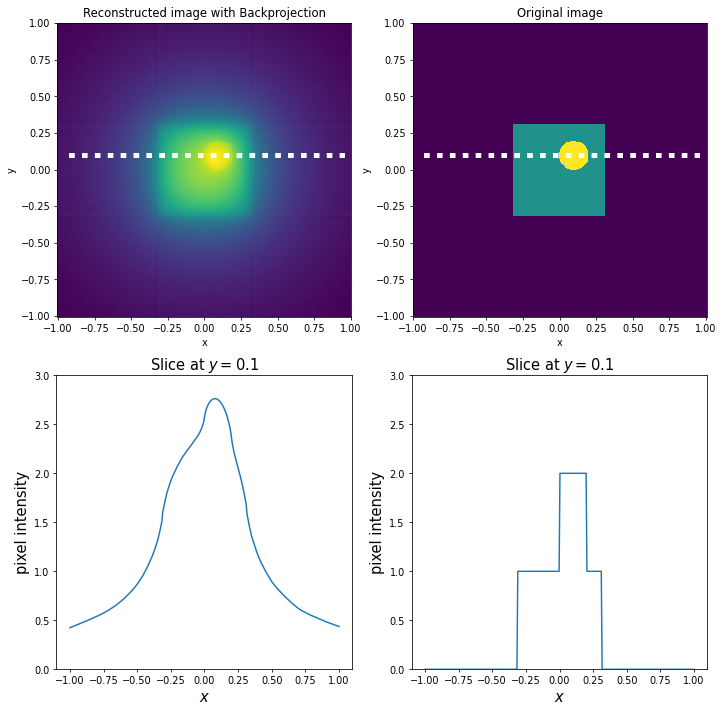

In [34]:
fig, ax = plt.subplots(2,2, figsize=(12,12))


y_coord = 0.1
idxs = find_all_x_given_y_coordinate(y_coord,xv,yv)

ax[0][0].pcolor(xv,yv,f_BP, shading='auto')
ax[0][0].set_title('Reconstructed image with Backprojection')
ax[0][0].set_xlabel('x')
ax[0][0].set_ylabel('y')
ax[0][0].set_aspect('equal')
ax[0][0].arrow(-0.95, y_coord, 1.9, 0, head_width=0.0, head_length=0.0,lw=5, fc='white', ec='white',ls=':')


ax[0][1].pcolor(xv,yv,image, shading='auto')
ax[0][1].set_title('Original image')
ax[0][1].set_xlabel('x')
ax[0][1].set_ylabel('y')
ax[0][1].set_aspect('equal')
ax[0][1].arrow(-0.95, y_coord, 1.9, 0, head_width=0.0, head_length=0.0,lw=5, fc='white', ec='white',ls=':')

ax[1][0].plot(r_axis,f_BP[idxs])
ax[1][0].set_xlabel(r'$x$',fontsize=15)
ax[1][0].set_ylabel('pixel intensity',fontsize=15)
ax[1][0].set_title(r'Slice at $y=$'+str(y_coord),fontsize=15)
ax[1][0].set_ylim([0,3])

ax[1][1].plot(r_axis,image[idxs])
ax[1][1].set_xlabel(r'$x$',fontsize=15)
ax[1][1].set_ylabel('pixel intensity',fontsize=15)
ax[1][1].set_title(r'Slice at $y=$'+str(y_coord),fontsize=15)
ax[1][1].set_ylim([0,3])


plt.show()